# FT3.2模型评审文档

In [3]:
import sys
sys.path.append("/Users/wj/新浪数科/模型开发/")

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import scorecardpy as sc
import pickle
from model_tools.metrics import roc_auc_score, ks
from model_tools.ScoreCard import model_helper
from model_tools.Model import model_utils

import warnings
warnings.filterwarnings("ignore")

In [4]:
model_data = pd.read_csv("../input/FT4_0_MODEL_DATA_230418.csv")

In [5]:
loan_behavior_data = pd.read_csv("../input/ft4_0_loan_behavior_variables_20230509.csv")
loan_behavior_variables = list(loan_behavior_data.columns[8:])
model_data.drop(['dpd30_at_mob6'], axis=1, inplace=True)
model_data = model_data.merge(loan_behavior_data[['biz_id', 'loan_credit_diffday', 'dpd15_at_mob1', 'dpd30_at_mob6']+loan_behavior_variables], left_on='loan_id', right_on='biz_id', how='left')

In [6]:
loan_behavior_variables = ['loan_apply_count',
 'loan_apply_count_15d',
 'loan_apply_count_30d',
 'loan_apply_count_60d',
 'loan_apply_count_90d',
 'loan_apply_count_180d',
 'loan_apply_count_360d',
 'loan_term3_apply_count',
 'loan_term6_apply_count',
 'loan_term12_apply_count',
 'loan_hour06_apply_count',
 'loan_hour12_apply_count',
 'loan_hour18_apply_count',
 'loan_hour24_apply_count',
 'first_reject_to_now_days',
 'recent_reject_to_now_days']

In [7]:
# 额度使用率
limit_used_data = pd.read_csv("../input/limit_used_rate_data.csv")
limit_used_data['limit_used_rate'] = limit_used_data['apply_amount']/limit_used_data['orders_curr_total_limit']

loan_behavior_variables_2 = [
    'bankcardauthcount', 'communicationauthcount',
   'emercontactcount', 'bank_phone_same', 'location_same_province',
   'diff_storage_mobile_time', 'diff_storage_credit_time',
   'diff_mobile_bank_time', 'diff_bank_carrier_time',
   'diff_carrier_credit_time', 'first_credit_hour', 'first_credit_week',
   'first_credit_weekend', 
   'first_credit_succ_hour', 'first_credit_succ_week',
   'first_credit_succ_weekend', 'first_loan_hour', 'first_loan_week',
   'first_loan_weekend', 'diff_wb_reg_first_loan_time',
   'diff_wb_reg_first_credit_time', 'city_level_card_num',
   'city_level_mobile_num', 'city_level_bank_num', 'mobile_unbound_times',
    'user_name_is_figure_or_alphabet',
   'emer_contact_user1_name_is_figure_or_alphabet',
   'emer_contact_user2_name_is_figure_or_alphabet',
   'user_emer1_emer2_name_no_equal', 'user_emer1_emer2_mobile_no_equal',
   'id_card_expire_diff_now_days', 'cardfrontkeysize', 'cardbackkeysize',
   'contracts_count', 
   'limit_used_rate', 
   'wheneverloan_loan_info_diff_pass_credit_first_loan_time',
]

limit_used_data.rename(columns={'biz_id': 'loan_id'}, inplace=True)
model_data = model_data.merge(limit_used_data[['loan_id']+loan_behavior_variables_2], on='loan_id', how='left')

In [8]:
import math
from six.moves import xrange
from catboost import Pool, CatBoostClassifier


class FocalLossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        gamma = 2.
        # alpha = 1.
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        exponents = []
        for index in xrange(len(approxes)):
            exponents.append(math.exp(approxes[index]))

        result = []
        for index in xrange(len(targets)):
            p = exponents[index] / (1 + exponents[index])

            if targets[index] > 0.0:
                der1 = -((1-p)**(gamma-1))*(gamma * math.log(p) * p + p - 1)/p
                der2 = gamma*((1-p)**gamma)*((gamma*p-1)*math.log(p)+2*(p-1))
            else:
                der1 = (p**(gamma-1)) * (gamma * math.log(1 - p) - p)/(1 - p)
                der2 = p**(gamma-2)*((p*(2*gamma*(p-1)-p))/(p-1)**2 + (gamma-1)*gamma*math.log(1 - p))

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result

In [9]:
import joblib
import math

def score_card(prob):
    base_score = 600
    base_odds = 1/50
    PDO = 50
    B = PDO*1.0/math.log(2)
    A = base_score + B*math.log(base_odds)
    return round(A - B*math.log( prob/ (1-prob+1e-20)),0)

def lgb_pkl_score(df, model_pkl_path,score_name,predict_pos_neg=1,return_list=[],both_score_with_prob=True):
    model = joblib.load(open(model_pkl_path,"rb"))
    model_features_list = model.feature_name_
    df[model_features_list] = df[model_features_list].replace(['none', 'none\t', -9999, -99, -999, -88888, -99999, -9999999, -2, -1], np.nan)
    model_result = df[return_list]
    model_result[score_name] = model.predict_proba(df[model_features_list])[:, predict_pos_neg]
    if both_score_with_prob:
        model_result[score_name.replace("prob","score")] = model_result[score_name].apply(score_card)
    return model_result

In [10]:
# Titan3.2打分
model_data[['titan_v3_2_prob', 'titan_v3_2_score']] = lgb_pkl_score(df=model_data, model_pkl_path='../model/Titan_V3_2_model.pkl',score_name='titan_v3_2_prob',predict_pos_neg=1,both_score_with_prob=True).values

In [11]:
# FT3.2打分
ft3_2_model_v1 = pickle.load(open("../model/ft3_2_model_v1_final.pkl", "rb"))
ft3_2_model_v1_input = [x for x in ft3_2_model_v1.feature_names_]

import condition_calculate_mob6_input
from imp import reload
reload(condition_calculate_mob6_input)

model_data = condition_calculate_mob6_input.process(model_data)

model_data['ft_v3_2_prob'] = ft3_2_model_v1.predict_proba(model_data[ft3_2_model_v1_input])[:,1]
model_data['ft_v3_2_score'] = model_data['ft_v3_2_prob'].apply(score_card)

In [12]:
def source_map(x):
    if x<'2022-08':
        return '0.Train'
    else:
        return '1.OOT'

model_data['source'] = model_data['apply_month'].apply(lambda x: source_map(x))

In [13]:
model_data['firsr_loan_seg'] = model_data['loan_apply_count'].apply(lambda x: 0 if x>0 else 1)

In [14]:
# FT3.1分数
ft3_1_score = pd.read_csv("../input/ft3_1_score.csv")
model_data.drop(['dpd30_at_mob6'], axis=1, inplace=True)
model_data = model_data.merge(ft3_1_score, on='loan_id', how='left')

In [15]:
# comment
comment_doc = pd.read_excel("../doc/FT_V3_2数据字典.xlsx")

In [16]:
comment_doc.head()

,feature_name,变量大类,变量含义
0,age,内部特征,年龄
1,gender,内部特征,性别
2,idcardpre6,内部特征,idcardpre6
3,diff_pass_credit_first_loan_time,支用行为,首支距授信时间差
4,loan_apply_count,支用行为,支用申请次数


## 1.建模样本分布

### 1.1 Train/OOT分布

In [17]:
target = "dpd30_at_mob6"

In [18]:
def f_mi_1(x, proba_name, target):
    d = []
    d.append(x['cnt'].sum())
    d.append(x.query(f"{target}==0")['cnt'].sum())
    d.append(x.query(f"{target}==-1")['cnt'].sum())
    d.append(x.query(f"{target}==1")['cnt'].sum())
    d.append(x.query(f"{target}==-1")['cnt'].sum()/x['cnt'].sum())
    d.append(x.query(f"{target}==1")['cnt'].sum()/x.query(f"{target}!=-1")['cnt'].sum())
    d.append(x[target].replace(-1, 0).sum()/x['cnt'].sum())
    return pd.Series(d, index=['总样本量', '白样本量', '灰样本量', '黑样本量', '灰样本率', '黑样本率_不含灰', '黑样本率_灰当白'])

model_data['cnt'] = 1
model_data.query("dpd30_at_mob6 != -9999").groupby(['source']).apply(lambda x: f_mi_1(x, None, target))

,总样本量,白样本量,灰样本量,黑样本量,灰样本率,黑样本率_不含灰,黑样本率_灰当白
source,,,,,,,
0.Train,63365.0,42327.0,15242.0,5796.0,0.240543,0.120441,0.09147
1.OOT,32945.0,22683.0,7916.0,2346.0,0.240279,0.093731,0.07121


In [19]:
model_data.query("dpd30_at_mob6 != -9999").groupby(['cnt']).apply(lambda x: f_mi_1(x, None, target))

,总样本量,白样本量,灰样本量,黑样本量,灰样本率,黑样本率_不含灰,黑样本率_灰当白
cnt,,,,,,,
1,96310.0,65010.0,23158.0,8142.0,0.240453,0.111302,0.08454


### 1.2 逐月分布

In [20]:
model_data.query("dpd30_at_mob6 != -9999").groupby(['source', 'apply_month']).apply(lambda x: f_mi_1(x, None, target))

总样本量     白样本量    灰样本量    黑样本量      灰样本率  黑样本率_不含灰  \
source  apply_month                                                         
0.Train 2022-04      13513.0   8959.0  3334.0  1220.0  0.246725  0.119855   
        2022-05      18620.0  12200.0  4715.0  1705.0  0.253222  0.122618   
        2022-06      16490.0  11064.0  3826.0  1600.0  0.232019  0.126342   
        2022-07      14742.0  10104.0  3367.0  1271.0  0.228395  0.111736   
1.OOT   2022-08      13659.0   9265.0  3286.0  1108.0  0.240574  0.106816   
        2022-09      12574.0   8856.0  2958.0   760.0  0.235247  0.079035   
        2022-10       6712.0   4562.0  1672.0   478.0  0.249106  0.094841   

                     黑样本率_灰当白  
source  apply_month            
0.Train 2022-04      0.090283  
        2022-05      0.091568  
        2022-06      0.097029  
        2022-07      0.086216  
1.OOT   2022-08      0.081119  
        2022-09      0.060442  
        2022-10      0.071216

In [21]:
# model_data.query("dpd30_at_mob6 != -9999").groupby(['segment_2']).apply(lambda x: f_mi_1(x, None, target))

## 2.特征空间

### 2.1 特征空间变量分布

In [22]:
def f_mi_2(x, proba_name, target):
    d = []
    d.append(x['cnt'].sum())
    return pd.Series(d, index=['#特征个数'])

comment_doc['cnt'] = 1
comment_doc.groupby(['变量大类']).apply(lambda x: f_mi_2(x, None, target))

,#特征个数
变量大类,
京东地址基础画像标准版,3
京东画像指标1,5
京东画像指标2,4
内部特征,3
华道授信履约评估,81
友盟银行分v6_9,1
度小满欺诈因子V3,1
微博融合子分,2
支用行为,14


### 2.2 入模特征变量分布

In [23]:
ft3_2_model_v1_input_ori = [x[2:] for x in ft3_2_model_v1_input]

comment_doc.query("feature_name==@ft3_2_model_v1_input_ori").groupby(['变量大类']).apply(lambda x: f_mi_2(x, None, target))

,#特征个数
变量大类,
京东画像指标2,3
内部特征,3
友盟银行分v6_9,1
度小满欺诈因子V3,1
微博融合子分,2
支用行为,3
旷视借贷评估标签标准版,8
百维天玑分V3,1
百融借贷意向验证,47


In [24]:
comment_doc.query("feature_name==@ft3_2_model_v1_input_ori").groupby(['cnt']).apply(lambda x: f_mi_2(x, None, target))

,#特征个数
cnt,
1,80


### 2.3 TOP20特征WOE分布

In [27]:
mapiv_1 = pd.read_csv("../output/mono_woe_mob6_final.csv")

break_dict = {}
for col in ft3_2_model_v1_input_ori[:25]:
    temp_ = mapiv_1.query(f"varname=='{col}'")
    break_list = [x for x in temp_['ll'].tolist() if x not in [-np.inf] and not pd.isnull(x)]
    break_dict[col] = break_list

In [28]:
def create_bin(in_data, variable, boundary_list, combine_missing_to='alone'):
    seq_num = 1
    zfill_len = len(str(len(boundary_list) + 2))
    boundary_left = -np.inf
    boundary_list.append(np.inf)
    out_series = pd.Series(index=in_data.index)
    for e, i in enumerate(boundary_list):
        values_unique = in_data[(in_data[variable] >= boundary_left) & (
            in_data[variable] < i)][variable].unique()
        min_value = boundary_left
        max_value = i
        if i == np.inf:
            bin_value = '{0}. [{1}, inf)'.format(
                str(seq_num).zfill(zfill_len), str(min_value))
        else:
            bin_value = '{0}. [{1}, {2})'.format(
                str(seq_num).zfill(zfill_len), str(min_value), str(max_value))
        if e == 0:
            bin_value = '{0}. [{1}, {2})'.format(
                str(seq_num).zfill(zfill_len), str(min_value), str(max_value))
        if combine_missing_to.lower() == 'top':
            if seq_num == 1:
                out_series = pd.Series(
                    np.where(
                        ((in_data[variable] > boundary_left) & (
                            in_data[variable] <= i)) | in_data[variable].isnull(),
                        bin_value + ' | NaN', out_series), index=in_data.index)
            else:
                out_series = pd.Series(
                    np.where((in_data[variable] >= boundary_left) & (
                        in_data[variable] <= i), bin_value, out_series),
                    index=in_data.index)
        elif combine_missing_to.lower() == 'bottom':
            if seq_num == len(boundary_list):
                out_series = pd.Series(
                    np.where(
                        ((in_data[variable] >= boundary_left) & (
                            in_data[variable] < i)) | in_data[variable].isnull(),
                        bin_value + ' | NaN', out_series), index=in_data.index)
            else:
                out_series = pd.Series(
                    np.where((in_data[variable] >= boundary_left) & (
                        in_data[variable] < i), bin_value, out_series),
                    index=in_data.index)
        else:
            out_series = pd.Series(
                np.where((in_data[variable] >= boundary_left) & (
                    in_data[variable] < i), bin_value, out_series),
                index=in_data.index)
            if seq_num == len(boundary_list):
                out_series = pd.Series(np.where(
                    in_data[variable].isnull(), '0. NaN', out_series), index=in_data.index)
        seq_num += 1
        boundary_left = max_value
    del bin_value, boundary_left, boundary_list, combine_missing_to, i, max_value, min_value, seq_num
    del values_unique, variable, zfill_len
    return out_series

In [29]:
data_concat = model_data.query("dpd30_at_mob6==[0, 1]")

target = 'dpd30_at_mob6'
agg_result = pd.DataFrame()
for variable in ft3_2_model_v1_input_ori[:25]:
    break_list = break_dict[variable]
    data_concat[variable+"_bin"] = create_bin(data_concat, variable, break_list)
    num_aggregations = {
        target: ['count', 'mean']
    }
    data_agg = data_concat.groupby(["source", variable+"_bin"]).agg({**num_aggregations}).reset_index()
    data_agg.columns = ["source", "Bin", "Count", "Bad"]
    data_agg["Bad"] *= 100
    data_agg["adjust_coef"] = (data_agg["Count"]/(data_agg["Bad"]+0.1)).apply(lambda x: np.ceil(x/1000)*1000)
    data_agg["adjust_bad"] = data_agg["Bad"]*data_agg["adjust_coef"].max()
    data_agg.insert(0, 'Variable', variable)
    agg_result = pd.concat([agg_result, data_agg])

In [29]:
# agg_result.query("source=='0.Train'").to_csv("../output/ft3_2_bin_train_distribution.csv", index=False)

In [30]:
woe_distribution = pd.DataFrame(ft3_2_model_v1_input_ori, columns=['特征名'])

In [31]:
comment_doc.head()

,feature_name,变量大类,变量含义,cnt
0,age,内部特征,年龄,1
1,gender,内部特征,性别,1
2,idcardpre6,内部特征,idcardpre6,1
3,diff_pass_credit_first_loan_time,支用行为,首支距授信时间差,1
4,loan_apply_count,支用行为,支用申请次数,1


In [32]:
woe_distribution = woe_distribution.merge(comment_doc, left_on='特征名', right_on='feature_name', how='left')

In [33]:
woe_distribution = woe_distribution.merge(mapiv_1[['varname', 'iv']].drop_duplicates(), left_on='特征名', right_on='varname', how='left')

In [34]:
importance = pd.DataFrame([ft3_2_model_v1_input_ori, ft3_2_model_v1.feature_importances_]).T
importance.columns = ['feature_name', 'importance']

In [35]:
woe_distribution = woe_distribution.merge(importance, on='feature_name', how='left')

In [36]:
woe_distribution.sort_values(['importance'], ascending=False, inplace=True)

In [37]:
woe_distribution.reset_index(drop=True, inplace=True)

In [38]:
woe_distribution['一级分类'] = woe_distribution['变量大类'].apply(lambda x:x[:4])
woe_distribution['WOE'] = np.nan

In [39]:
woe_distribution.head()

,特征名,feature_name,变量大类,变量含义,cnt,varname,iv,importance,一级分类,WOE
0,wb_v2_0_prob,wb_v2_0_prob,微博融合子分,微博融合子分2.0prob,1,wb_v2_0_prob,0.295186,11.067217,微博融合,NaN
1,dxm_general_fraudc_v3_score,dxm_general_fraudc_v3_score,度小满欺诈因子V3,度小满欺诈因子V3,1,dxm_general_fraudc_v3_score,0.236733,10.791678,度小满欺,NaN
2,bw_b_score_v3,bw_b_score_v3,百维天玑分V3,朴道百维天玑分V3,1,bw_b_score_v3,0.184004,9.566885,百维天玑,NaN
3,tx_riskscore,tx_riskscore,腾讯风险分层分,百行_腾讯风险分层分,1,tx_riskscore,0.212808,6.029308,腾讯风险,NaN
4,age,age,内部特征,年龄,1,age,0.043311,5.173249,内部特征,NaN


In [40]:
woe_distribution[['一级分类', '变量大类', '特征名', '变量含义', 'WOE', 'iv', 'importance']].to_excel("../doc/ft3_2_woe_distribution.xlsx")

## 3.模型效果评估

### 3.1 整体AUC/KS/Lift

In [25]:
def capture_topk(y_ture, y_pred, top=20):
    sort_index = np.argsort(-y_pred)
    y_ture_sort = y_ture[sort_index]
    topk = int(len(y_pred)*top/100)
    return np.sum(y_ture_sort[:topk])/np.sum(y_ture_sort)


def lift_topk(y_ture, y_pred, top=20):
    sort_index = np.argsort(-y_pred)
    y_ture_sort = y_ture[sort_index]
    topk = int(len(y_pred)*top/100)
    return (np.sum(y_ture_sort[:topk])/topk)/(np.sum(y_ture_sort)/len(y_ture))

# def lift_repair(data, cut_off, target, score, adjust_bad_rate, adjust_good_rate):
#     rj_sample_1 = data.query(f"{score} < @cut_off and {target}==1").shape[0]
#     rj_sample_0 = data.query(f"{score} < @cut_off and {target}==0").shape[0]
#     ps_sample_1 = data.query(f"{score} >= @cut_off and {target}==1").shape[0]
#     ps_sample_0 = data.query(f"{score} >= @cut_off and {target}==0").shape[0]
#     l = (rj_sample_1/adjust_bad_rate)/(rj_sample_1/adjust_bad_rate+rj_sample_0/adjust_good_rate)*\
#     (1+(rj_sample_0/adjust_good_rate +ps_sample_0/adjust_good_rate)/(rj_sample_1/adjust_bad_rate+ps_sample_1/adjust_bad_rate))
#     return l

def lift_repair_topk(y_ture, y_pred, adjust_bad_rate, adjust_good_rate, top=20):
    sort_index = np.argsort(-y_pred)
    y_ture_sort = y_ture[sort_index]
    topk = int(len(y_pred)*top/100)
    rj_sample_1 = np.sum(y_ture_sort[:topk])
    rj_sample_0 = topk - rj_sample_1
    ps_sample_1 = np.sum(y_ture_sort[topk:])
    ps_sample_0 = len(y_ture_sort[topk:]) - ps_sample_1
    return (rj_sample_1/adjust_bad_rate)/(rj_sample_1/adjust_bad_rate+rj_sample_0/adjust_good_rate)*\
    (1+(rj_sample_0/adjust_good_rate +ps_sample_0/adjust_good_rate)/(rj_sample_1/adjust_bad_rate+ps_sample_1/adjust_bad_rate))

def f_evalutor_3(x, proba_name, target):
    d = []
    d.append(x['cnt'].sum())
    d.append(x.query(f"{target}==[0, 1]")[target].sum())
    d.append(x.query(f"{target}==[0, 1]")[target].mean())
    d.append(x[target].replace(-1, 0).mean())
    d.append(round(roc_auc_score(x.query(f"{target}!=-1")[target], -1*x.query(f"{target}!=-1")[proba_name]), 3))
    d.append(round(ks(x.query(f"{target}!=-1")[target], x.query(f"{target}!=-1")[proba_name]),3))
    d.append(round(roc_auc_score(x[target].replace(-1, 0), -1*x[proba_name]),3))
    d.append(round(ks(x[target].replace(-1, 0), x[proba_name]),3))
    # capture@top10%
    d.append(round(capture_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")[proba_name].values, 10), 3))
    # lift@top10%
    d.append(round(lift_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")[proba_name].values, 10), 3))
    # lift_repair@top10%
    d.append(round(lift_repair_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")[proba_name].values, 0.44, 0.16, 10), 3))
    return pd.Series(d, index=['#Count', '#Bad', '%Bad', '%Bad(灰当白)', 'AUC', 'KS', 'AUC(灰当白)', 'KS(灰当白)', 'Capture@top10%', 'Lift@top10%', 'Lift_Repair@top10%'])


model_data.query("dpd30_at_mob6!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3(x, "ft_v3_2_score", "dpd30_at_mob6"))

,#Count,#Bad,%Bad,%Bad(灰当白),AUC,KS,AUC(灰当白),KS(灰当白),Capture@top10%,Lift@top10%,Lift_Repair@top10%
source,,,,,,,,,,,
0.Train,63365.0,5796.0,0.120441,0.09147,0.787,0.426,0.769,0.397,0.335,3.351,4.163
1.OOT,32945.0,2346.0,0.093731,0.07121,0.740,0.360,0.722,0.334,0.280,2.797,3.157


In [26]:
model_data.query("dpd30_at_mob6!=-9999").groupby(["source", "apply_month"]).apply(lambda x: f_evalutor_3(x, "ft_v3_2_score", "dpd30_at_mob6"))

#Count    #Bad      %Bad  %Bad(灰当白)    AUC     KS  \
source  apply_month                                                       
0.Train 2022-04      13513.0  1220.0  0.119855   0.090283  0.785  0.425   
        2022-05      18620.0  1705.0  0.122618   0.091568  0.791  0.429   
        2022-06      16490.0  1600.0  0.126342   0.097029  0.786  0.429   
        2022-07      14742.0  1271.0  0.111736   0.086216  0.787  0.430   
1.OOT   2022-08      13659.0  1108.0  0.106816   0.081119  0.745  0.377   
        2022-09      12574.0   760.0  0.079035   0.060442  0.727  0.334   
        2022-10       6712.0   478.0  0.094841   0.071216  0.747  0.371   

                     AUC(灰当白)  KS(灰当白)  Capture@top10%  Lift@top10%  \
source  apply_month                                                   
0.Train 2022-04         0.762    0.389           0.334        3.347   
        2022-05         0.774    0.403           0.349        3.491   
        2022-06         0.767    0.399           0.324        3.239   
        2022-07         0.770    0.406           0.328        3.282   
1.OOT   2022-08         0.727    0.352           0.270        2.699   
        2022-09         0.710    0.311           0.282        2.818   
        2022-10         0.727    0.340           0.272        2.720   

                     Lift_Repair@top10%  
source  apply_month                      
0.Train 2022-04                   4.152  
        2022-05                   4.424  
        2022-06                   4.027  
        2022-07                   3.977  
1.OOT   2022-08                   3.081  
        2022-09                   3.118  
        2022-10                   3.057

### 3.2 与Titan3.2/FT3.1对比

#### 3.2.1 效果对比

In [42]:
model_data.query("source=='1.OOT' and dpd30_at_mob6!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3(x, "titan_v3_2_score", "dpd30_at_mob6"))

,#Count,#Bad,%Bad,%Bad(灰当白),AUC,KS,AUC(灰当白),KS(灰当白),Capture@top10%,Lift@top10%,Lift_Repair@top10%
source,,,,,,,,,,,
1.OOT,32945.0,2346.0,0.093731,0.07121,0.703,0.301,0.689,0.279,0.246,2.456,2.706


In [43]:
model_data.query("dpd30_at_mob6!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3(x, "ft_v3_1_score", "dpd30_at_mob6"))

,#Count,#Bad,%Bad,%Bad(灰当白),AUC,KS,AUC(灰当白),KS(灰当白),Capture@top10%,Lift@top10%,Lift_Repair@top10%
source,,,,,,,,,,,
0.Train,63365.0,5796.0,0.120441,0.09147,0.696,0.284,0.680,0.261,0.240,2.400,2.716
1.OOT,32945.0,2346.0,0.093731,0.07121,0.672,0.254,0.657,0.231,0.209,2.089,2.245


In [44]:
model_data.query("source == '1.OOT'")[['ft_v3_2_score', 'titan_v3_2_score']].corr()

,ft_v3_2_score,titan_v3_2_score
ft_v3_2_score,1.000000,0.793319
titan_v3_2_score,0.793319,1.000000


#### 3.2.2 短中长期风险效果对比

In [45]:
def f_evalutor_3_3(x, proba_name, target):
    d = []
    d.append(x['cnt'].sum())
    d.append(x.query(f"{target}==[0, 1]")[target].sum())
    d.append(x.query(f"{target}==[0, 1]")[target].mean())
    d.append(x[target].replace(-1, 0).mean())
    # AUC
    d.append(round(roc_auc_score(x.query(f"{target}!=-1")[target], -1*x.query(f"{target}!=-1")["ft_v3_2_score"]), 3))
    d.append(round(roc_auc_score(x.query(f"{target}!=-1")[target], -1*x.query(f"{target}!=-1")["titan_v3_2_score"]), 3))
    d.append(round(roc_auc_score(x.query(f"{target}!=-1")[target], -1*x.query(f"{target}!=-1")["ft_v3_1_score"]), 3))
    # KS
    d.append(round(ks(x.query(f"{target}!=-1")[target], x.query(f"{target}!=-1")["ft_v3_2_score"]),3))
    d.append(round(ks(x.query(f"{target}!=-1")[target], x.query(f"{target}!=-1")["titan_v3_2_score"]),3))
    d.append(round(ks(x.query(f"{target}!=-1")[target], x.query(f"{target}!=-1")["ft_v3_1_score"]),3))
    # lift_repair@top10%
    d.append(round(lift_repair_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")["ft_v3_2_score"].values, 0.44, 0.16, 10), 3))
    d.append(round(lift_repair_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")["titan_v3_2_score"].values, 0.44, 0.16, 10), 3))
    d.append(round(lift_repair_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")["ft_v3_1_score"].values, 0.44, 0.16, 10), 3))
    return pd.Series(d, index=['#Count', '#Bad', '%Bad', '%Bad(灰当白)', 'FT3.2', 'Titan3.2', 'FT3.1', 'FT3.2', 'Titan3.2', 'FT3.1', 'FT3.2', 'Titan3.2', 'FT3.1'])

model_data.query("source=='1.OOT' and dpd30_at_mob6!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3_3(x, "", "dpd30_at_mob6"))

,#Count,#Bad,%Bad,%Bad(灰当白),FT3.2,Titan3.2,FT3.1,FT3.2,Titan3.2,FT3.1,FT3.2,Titan3.2,FT3.1
source,,,,,,,,,,,,,
1.OOT,32945.0,2346.0,0.093731,0.07121,0.741,0.703,0.672,0.361,0.301,0.254,3.198,2.706,2.245


In [46]:
model_data.query("source=='1.OOT' and dpd30_at_mob3!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3_3(x, "", "dpd30_at_mob3"))

,#Count,#Bad,%Bad,%Bad(灰当白),FT3.2,Titan3.2,FT3.1,FT3.2,Titan3.2,FT3.1,FT3.2,Titan3.2,FT3.1
source,,,,,,,,,,,,,
1.OOT,39118.0,1640.0,0.050256,0.041924,0.757,0.712,0.685,0.387,0.316,0.275,3.358,2.827,2.423


In [47]:
model_data.query("source=='1.OOT' and dpd15_at_mob1!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3_3(x, "", "dpd15_at_mob1"))

,#Count,#Bad,%Bad,%Bad(灰当白),FT3.2,Titan3.2,FT3.1,FT3.2,Titan3.2,FT3.1,FT3.2,Titan3.2,FT3.1
source,,,,,,,,,,,,,
1.OOT,39118.0,351.0,0.009558,0.008973,0.761,0.731,0.704,0.409,0.35,0.31,3.766,3.412,2.882


#### 3.2.3 等深Bad Rate

In [48]:
def KS_bucket(df, target, model_score, higher_better = True, number_of_groups = 10):
    df = df[df[target].notnull()]
    df = df.copy().reset_index().drop('index', axis = 1)
    try:
        bins = pd.DataFrame(pd.qcut(df[model_score], number_of_groups, labels = False, 
                                    duplicates = 'drop')).rename(columns = {model_score: 'bin_group'})
    except:
        try:
            bins = pd.DataFrame(pd.qcut(df[model_score], number_of_groups, labels = False)).rename(columns = {model_score: 'bin_group'})
        except:
            bins = pd.DataFrame(pd.cut(df[model_score], number_of_groups, labels = False)).rename(columns = {model_score: 'bin_group'})
    
    if higher_better == False:
        bins['adverse_bin_group'] = bins['bin_group'].apply(lambda x: number_of_groups - 1 - x)
        bins.drop('bin_group', axis = 1, inplace = True)
        bins.rename(columns = {'adverse_bin_group': 'bin_group'}, inplace = True)
    
    df = df.merge(bins, how = 'left', left_index = True, right_index = True)
    
    df['cnt_group'] = 1
    df['cnt_bad'] = df[target].apply(lambda x: 1 if x == 1 else 0)
    df['cnt_good'] = df[target].apply(lambda x: 1 if x == 0 else 0)
    df[model_score + '_min'] = df[model_score]
    df[model_score + '_max'] = df[model_score]
    df[model_score + '_avg'] = df[model_score]
    
    df_grouped = df.groupby('bin_group').agg({'cnt_group': np.sum, 'cnt_bad': np.sum, 'cnt_good': np.sum,
        model_score + '_min': np.min, model_score + '_max': np.max, model_score + '_avg': np.average})
    df_grouped['group_bad_rate'] = df_grouped['cnt_bad'] / df_grouped['cnt_group']
    
    df_grouped['total_bad'] = np.sum(df_grouped['cnt_bad'])
    df_grouped['total_good'] = np.sum(df_grouped['cnt_good'])
    df_grouped['total_bad_rate'] = df_grouped['total_bad'] / (df_grouped['total_bad'] + df_grouped['total_good'])
    
    df_grouped['cum_bad'] = df_grouped['cnt_bad'].cumsum()
    df_grouped['cum_good'] = df_grouped['cnt_good'].cumsum()
    
    df_grouped['cum_bad_pct'] = df_grouped['cum_bad'] / df_grouped['total_bad']
    df_grouped['cum_good_pct'] = df_grouped['cum_good'] / df_grouped['total_good']
    df_grouped['KS'] = df_grouped['cum_bad_pct'] - df_grouped['cum_good_pct']
    df_grouped['KS'] = df_grouped['KS'].apply(lambda x: abs(x))
    
    df_grouped = df_grouped.reset_index()
    df_grouped['bin_group'] = df_grouped['bin_group'].apply(lambda x: x + 1)
    df_grouped['bins'] = ["(%d%%,%d%%]"%(i*100/number_of_groups,100/number_of_groups*(i+1)) for i in range(number_of_groups)]
    df_grouped['lift'] = df_grouped['group_bad_rate'] / df_grouped['total_bad_rate']
    df_grouped = df_grouped[['bin_group','bins','total_bad', 'total_good', 'total_bad_rate', 'cnt_group', 'cnt_bad', 
                                       'cnt_good', 'group_bad_rate', 'cum_bad', 'cum_good', 'cum_bad_pct', 'cum_good_pct','lift' ,'KS', 
                                       model_score + '_min', model_score + '_max', model_score + '_avg']]
    return df_grouped


def model_comparison_bad_rate_and_cum_good_pct(df,model_score_columns_list,target,bins,dataset_split_benchmark,higher_better=True):

    df_temp = df[[dataset_split_benchmark,target]+model_score_columns_list].query("{0}>=0".format(target))
    month_list = sorted(set(df[dataset_split_benchmark]))
    overall_comparison = pd.DataFrame()
    for model_score in model_score_columns_list:
        overall_comparison = KS_bucket(df_temp, target, model_score, higher_better, number_of_groups = bins)[['bins','group_bad_rate','cum_bad_pct']]
        overall_comparison['model_name'] = model_score

    monthly_comparison = pd.DataFrame()
    for model_score in model_score_columns_list:
        for month in month_list:
            df_temp_monthly = df_temp.query("{0}==@month".format(dataset_split_benchmark))
            monthly_comparison_temp =  KS_bucket(df_temp_monthly, target, model_score, higher_better, number_of_groups = bins)[['bins','group_bad_rate','cum_bad_pct']]
            monthly_comparison_temp['model_name'] = model_score   
            monthly_comparison_temp['month'] = month   
            monthly_comparison = monthly_comparison.append(monthly_comparison_temp,ignore_index=True)
    print("分bin整体bad_rate:")
    display(pd.pivot_table(overall_comparison,values=['group_bad_rate'], index=['bins'],columns=['model_name'], aggfunc='sum').sort_index(axis=1,ascending=False))
    
    print("分bin分月bad_rate:")
    display(pd.pivot_table(monthly_comparison,values=['group_bad_rate'], index=['bins'],columns=['model_name','month'], aggfunc='sum').sort_index(level=['model_name','month'],axis=1,ascending=[False,True]))
   
    print("分bin整体capture_rate:")
    display(pd.pivot_table(overall_comparison,values=['cum_bad_pct'], index=['bins'],columns=['model_name'], aggfunc='sum').sort_index(axis=1,ascending=False))
    
    print("分bin分月capture_rate:")
    display(pd.pivot_table(monthly_comparison,values=['cum_bad_pct'], index=['bins'],columns=['model_name','month'], aggfunc='sum').sort_index(level=['model_name','month'],axis=1,ascending=[False,True]))

model_comparison_bad_rate_and_cum_good_pct(df=model_data.query("source=='1.OOT' and dpd30_at_mob6==[0, 1]"),model_score_columns_list=['ft_v3_2_score','titan_v3_2_score', 'ft_v3_1_score'],target='dpd30_at_mob6',bins=10,dataset_split_benchmark='source',higher_better=True)

分bin整体bad_rate:


,group_bad_rate
model_name,ft_v3_1_score
bins,
"(0%,10%]",0.196934
"(10%,20%]",0.143891
"(20%,30%]",0.124608
"(30%,40%]",0.115072
"(40%,50%]",0.101181
"(50%,60%]",0.079443
"(60%,70%]",0.061134
"(70%,80%]",0.053174


分bin分月bad_rate:


group_bad_rate                            
model_name titan_v3_2_score ft_v3_2_score ft_v3_1_score
month                 1.OOT         1.OOT         1.OOT
bins                                                   
(0%,10%]           0.230556      0.264300      0.196934
(10%,20%]          0.162451      0.177734      0.143891
(20%,30%]          0.126119      0.126508      0.124608
(30%,40%]          0.109310      0.106184      0.115072
(40%,50%]          0.082208      0.072574      0.101181
(50%,60%]          0.069806      0.070908      0.079443
(60%,70%]          0.058072      0.047656      0.061134
(70%,80%]          0.048019      0.033731      0.053174
(80%,90%]          0.031173      0.024784      0.036697
(90%,100%]         0.015777      0.008140      0.019766

分bin整体capture_rate:


,cum_bad_pct
model_name,ft_v3_1_score
bins,
"(0%,10%]",0.213555
"(10%,20%]",0.366155
"(20%,30%]",0.501705
"(30%,40%]",0.628303
"(40%,50%]",0.737852
"(50%,60%]",0.820546
"(60%,70%]",0.884910
"(70%,80%]",0.939898


分bin分月capture_rate:


cum_bad_pct                            
model_name titan_v3_2_score ft_v3_2_score ft_v3_1_score
month                 1.OOT         1.OOT         1.OOT
bins                                                   
(0%,10%]           0.247656      0.285592      0.213555
(10%,20%]          0.422847      0.476130      0.366155
(20%,30%]          0.560955      0.614663      0.501705
(30%,40%]          0.673061      0.725916      0.628303
(40%,50%]          0.763853      0.803069      0.737852
(50%,60%]          0.835891      0.877664      0.820546
(60%,70%]          0.899829      0.929668      0.884910
(70%,80%]          0.950980      0.964621      0.939898
(80%,90%]          0.983376      0.991475      0.979113
(90%,100%]         1.000000      1.000000      1.000000

### 3.3 Capture Rate分析

#### 3.3.1 Lorenz对比

In [49]:
import matplotlib.pyplot as plt
def model_comparison_lorenz_curve(df,model_score_columns_list,target):
    #洛伦兹曲线
    def lorenz_curve(y_truth,y_pre,plot=True,title=''):
        """
        默认只支持y:0/1
        自动选择0/1中占比少的为正样本
        自动选择score约低/越高为正样本
        e.g.
        lorenz_curve(y_pre =[0.9,0.1,0.2,0.5],y_truth = [1,0,1,0])
        e.g.
        lorenz_curve(y_pre=df[['pre1','pre2','y']],y_truth='y')
        :param y_truth: "dpd30",df["dpd30"]
        :param y_pre:"v2"、df[['v31','v2]]
        :param plot: plot figure ?
        :param title: title prefix
        :return:
        """

        if isinstance(y_pre,pd.DataFrame):
            df = y_pre.copy()
            if isinstance (y_truth,str):
                y_col = y_truth
            else:
                y_col = y_truth.name
                if y_col not in df.columns:
                    df[y_col] = y_truth.values # 防止join

        else:
            df = pd.DataFrame({'y_predict':y_pre
                        ,'y_truth':y_truth
                        })
            y_col = 'y_truth'

        df = df[df[y_col]>=0]
        if df[y_col].mean()>0.5:
            df[y_col] = 1- df[y_col]


        df['coverage rate']=1

        col = list(df.columns)
        col.remove('coverage rate')
        col.remove(y_col)

        N = len(df[y_col])
        df_out = pd.DataFrame({'coverage rate':np.linspace(1/N,1,N)})

        areas = []
        for c in col:
            if df[df[y_col]==1][c].mean()>df[df[y_col]==0][c].mean():
                cum = df.sort_values(by=c,ascending=False)[y_col].cumsum()
            else:
                cum = df.sort_values(by=c,ascending=True)[y_col].cumsum()

            df_out[c] = (cum/cum.iloc[-1]).values
            area = (df_out['coverage rate'].diff()*(df_out[c].shift()
                                            +df_out[c])/2).sum()
        #         legends.append(c+"({:.2f})".format(area))
            areas.append([c,area])

        if plot:
            ax = df_out.plot(x='coverage rate'
                        ,y= col
                        ,figsize=(6,4)
                        ,title=title+' Lorenz, white rate:{:.2%} '.format(df[y_col].mean())
                        #,c='red'
                            )
            plt.legend([x[0]+"({:.4f})".format(x[1]) for x in areas])

            ax.set_ylabel("recall rate")
            plt.grid(b=True, ls=':')
            ax.plot([0,1],[0,1],linestyle='-')
            plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
            plt.xlim((-0.01, 1.02))
            plt.ylim((-0.01, 1.02))
            plt.xticks(np.arange(0, 1.1, 0.1))
            plt.yticks(np.arange(0, 1.1, 0.1))
            plt.xlabel('coverate rate', fontsize=13)
            plt.ylabel('recall rate', fontsize=13)
            plt.grid(b=True, ls=':')
            #plt.legend( fancybox=True, framealpha=0.8, fontsize=12)
            #loc='lower right',
    #         plt.title('Lorenz', fontsize=17)
            plt.savefig('Lorenz of {}.png'.format(title))
            plt.show()
        if plot:
            return areas,ax
        else:
            return areas,None

    df_temp = df.query("{0} >=0".format(target))

    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['savefig.dpi'] = 80 #图片像素

    lorenz_curve(
        df_temp[target]
        ,df_temp[model_score_columns_list]
        ,title='OOT总体'
        )


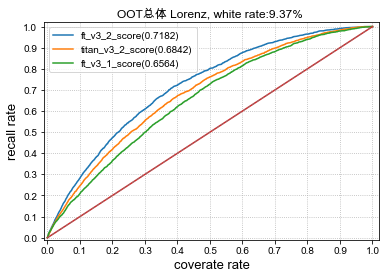

In [50]:
model_comparison_lorenz_curve(model_data.query("source == '1.OOT' and dpd30_at_mob6!=[-9999,-1]"),model_score_columns_list=['ft_v3_2_score', 'titan_v3_2_score','ft_v3_1_score'],target='dpd30_at_mob6')

### 3.4 分客群评估

#### 3.4.1 是否首次支用申请

In [51]:
model_data['segment_1'] = model_data['loan_apply_count'].apply(lambda x: '0.首次申请' if x==0 else '1.重复申请')

In [52]:
model_data.query("dpd30_at_mob6!=-9999").groupby(["source", "segment_1"]).apply(lambda x: f_evalutor_3(x, "ft_v3_2_score", "dpd30_at_mob6"))

#Count    #Bad      %Bad  %Bad(灰当白)    AUC     KS  \
source  segment_1                                                       
0.Train 0.首次申请     51868.0  4534.0  0.114152   0.087414  0.783  0.422   
        1.重复申请     11497.0  1262.0  0.150167   0.109768  0.792  0.422   
1.OOT   0.首次申请     28728.0  1947.0  0.088880   0.067774  0.739  0.358   
        1.重复申请      4217.0   399.0  0.127762   0.094617  0.736  0.356   

                   AUC(灰当白)  KS(灰当白)  Capture@top10%  Lift@top10%  \
source  segment_1                                                   
0.Train 0.首次申请        0.767    0.399           0.328        3.285   
        1.重复申请        0.762    0.377           0.346        3.464   
1.OOT   0.首次申请        0.722    0.333           0.284        2.841   
        1.重复申请        0.714    0.328           0.253        2.534   

                   Lift_Repair@top10%  
source  segment_1                      
0.Train 0.首次申请                  4.001  
        1.重复申请                  4.684  
1.OOT   0.首次申请                  3.194  
        1.重复申请                  2.932

#### 3.4.2 是否重授信

In [53]:
def segment_2(x):
    if x<=30:
        return '1.[0, 30]'
    elif x <= 180:
        return '2.(30, 180]'
    elif x > 180:
        return '3.(180, inf)'
    else:
        return np.nan
    
model_data['segment_2'] = model_data['loan_credit_diffday'].apply(segment_2)

In [54]:
model_data.query("dpd30_at_mob6!=-9999").groupby(["source", "segment_2"]).apply(lambda x: f_evalutor_3(x, "ft_v3_2_score", "dpd30_at_mob6"))

#Count    #Bad      %Bad  %Bad(灰当白)    AUC     KS  \
source  segment_2                                                          
0.Train 1.[0, 30]     43445.0  3901.0  0.118338   0.089792  0.784  0.421   
        2.(30, 180]    4691.0   409.0  0.107349   0.087188  0.738  0.366   
        3.(180, inf)  15229.0  1486.0  0.130948   0.097577  0.802  0.453   
1.OOT   1.[0, 30]     25270.0  1775.0  0.093137   0.070241  0.740  0.363   
        2.(30, 180]    2682.0   172.0  0.078111   0.064131  0.727  0.350   
        3.(180, inf)   4993.0   399.0  0.105864   0.079912  0.750  0.376   

                      AUC(灰当白)  KS(灰当白)  Capture@top10%  Lift@top10%  \
source  segment_2                                                      
0.Train 1.[0, 30]        0.768    0.396           0.327        3.271   
        2.(30, 180]      0.722    0.341           0.291        2.910   
        3.(180, inf)     0.776    0.410           0.366        3.663   
1.OOT   1.[0, 30]        0.723    0.336           0.282        2.818   
        2.(30, 180]      0.720    0.338           0.273        2.735   
        3.(180, inf)     0.725    0.344           0.291        2.914   

                      Lift_Repair@top10%  
source  segment_2                         
0.Train 1.[0, 30]                  4.014  
        2.(30, 180]                3.383  
        3.(180, inf)               4.834  
1.OOT   1.[0, 30]                  3.183  
        2.(30, 180]                3.008  
        3.(180, inf)               3.382

#### 3.4.3 资质分层V3

In [55]:
model_data.query("dpd30_at_mob6!=-9999").groupby(["source", "cust_group"]).apply(lambda x: f_evalutor_3(x, "ft_v3_2_score", "dpd30_at_mob6"))

#Count    #Bad      %Bad  %Bad(灰当白)    AUC     KS  \
source  cust_group                                                       
0.Train 优质客群        32290.0  2456.0  0.099594   0.076061  0.782  0.420   
        其他客群         4663.0   557.0  0.154508   0.119451  0.754  0.386   
        劣质客群         4125.0   549.0  0.183489   0.133091  0.769  0.396   
        高多头客群         774.0   109.0  0.184433   0.140827  0.738  0.377   
1.OOT   优质客群        20686.0  1290.0  0.081522   0.062361  0.745  0.367   
        其他客群         2838.0   261.0  0.121058   0.091966  0.712  0.329   
        劣质客群         2542.0   258.0  0.141680   0.101495  0.697  0.298   
        高多头客群         459.0    35.0  0.096154   0.076253  0.692  0.423   

                    AUC(灰当白)  KS(灰当白)  Capture@top10%  Lift@top10%  \
source  cust_group                                                   
0.Train 优质客群           0.767    0.395           0.333        3.327   
        其他客群           0.740    0.366           0.273        2.733   
        劣质客群           0.751    0.368           0.295        2.953   
        高多头客群          0.706    0.325           0.220        2.206   
1.OOT   优质客群           0.729    0.343           0.296        2.962   
        其他客群           0.699    0.307           0.211        2.113   
        劣质客群           0.679    0.270           0.236        2.366   
        高多头客群          0.674    0.390           0.229        2.311   

                    Lift_Repair@top10%  
source  cust_group                      
0.Train 优质客群                     3.948  
        其他客群                     3.369  
        劣质客群                     3.980  
        高多头客群                    2.627  
1.OOT   优质客群                     3.318  
        其他客群                     2.330  
        劣质客群                     2.736  
        高多头客群                    2.527

### 3.5 贷中新增逾期口径评估

In [118]:
loan_dpd_data = pd.read_csv("../input/loan_mob_ind.csv")

In [119]:
loan_dpd_data.head()

,user_id,biz_id,apply_date,mob,dpd15,dpd30
0,120625974,57212499,2022-08-30,5.0,0,0
1,120968474,57262124,2022-09-01,2.0,0,0
2,7813150,58004925,2022-09-21,4.0,0,0
3,45255116,57145976,2022-08-28,4.0,0,0
4,121223450,57346113,2022-09-03,5.0,0,0


In [120]:
def create_bin(in_data, variable, boundary_list, combine_missing_to='alone'):
    seq_num = 1
    zfill_len = len(str(len(boundary_list) + 2))
    boundary_left = -np.inf
    boundary_list.append(np.inf)
    out_series = pd.Series(index=in_data.index)
    for e, i in enumerate(boundary_list):
        values_unique = in_data[(in_data[variable] >= boundary_left) & (
            in_data[variable] < i)][variable].unique()
        min_value = boundary_left
        max_value = i
        if i == np.inf:
            bin_value = '{0}. [{1}, inf)'.format(
                str(seq_num).zfill(zfill_len), str(min_value))
        else:
            bin_value = '{0}. [{1}, {2})'.format(
                str(seq_num).zfill(zfill_len), str(min_value), str(max_value))
        if e == 0:
            bin_value = '{0}. [{1}, {2})'.format(
                str(seq_num).zfill(zfill_len), str(min_value), str(max_value))
        if combine_missing_to.lower() == 'top':
            if seq_num == 1:
                out_series = pd.Series(
                    np.where(
                        ((in_data[variable] > boundary_left) & (
                            in_data[variable] <= i)) | in_data[variable].isnull(),
                        bin_value + ' | NaN', out_series), index=in_data.index)
            else:
                out_series = pd.Series(
                    np.where((in_data[variable] >= boundary_left) & (
                        in_data[variable] <= i), bin_value, out_series),
                    index=in_data.index)
        elif combine_missing_to.lower() == 'bottom':
            if seq_num == len(boundary_list):
                out_series = pd.Series(
                    np.where(
                        ((in_data[variable] >= boundary_left) & (
                            in_data[variable] < i)) | in_data[variable].isnull(),
                        bin_value + ' | NaN', out_series), index=in_data.index)
            else:
                out_series = pd.Series(
                    np.where((in_data[variable] >= boundary_left) & (
                        in_data[variable] < i), bin_value, out_series),
                    index=in_data.index)
        else:
            out_series = pd.Series(
                np.where((in_data[variable] >= boundary_left) & (
                    in_data[variable] < i), bin_value, out_series),
                index=in_data.index)
            if seq_num == len(boundary_list):
                out_series = pd.Series(np.where(
                    in_data[variable].isnull(), '0. NaN', out_series), index=in_data.index)
        seq_num += 1
        boundary_left = max_value
    del bin_value, boundary_left, boundary_list, combine_missing_to, i, max_value, min_value, seq_num
    del values_unique, variable, zfill_len
    return out_series

In [121]:
def percentile_cut(data, variable, bins):
    bins = 5
    temp_ = data.query(f"{variable}=={variable}")
    prev_cut = min(temp_[variable]) - 1
    cuts = [prev_cut]
    reduced_cuts = 0
    for i in range(1, bins + 1):
        next_cut = np.percentile(temp_[variable], i * 100 / bins)
        if next_cut != prev_cut:
            cuts.append(next_cut)
        else:
            reduced_cuts = reduced_cuts + 1
        prev_cut = next_cut
    return cuts[1:-1]

In [116]:
all_result = pd.DataFrame()
for variable in ['ft_v3_2_score', 'ft_v3_1_score', 'titan_v3_2_score', 'pboc2_0_score']:
    print(variable)
    cross_data = loan_dpd_data.query("apply_date>='2022-08-01'").merge(model_data.query("source=='1.OOT' and segment_2=='1.[0, 30]'")[['loan_id', variable]], left_on='biz_id', right_on='loan_id', how='inner')
    break_list = percentile_cut(model_data.query("source=='1.OOT' and segment_2=='1.[0, 30]'"), variable, 5)
    cross_data[variable+"_bin"] = create_bin(cross_data, variable, break_list)
    result = cross_data.pivot_table(index=[variable+"_bin"],values=["dpd15"], columns=["mob"],aggfunc=[np.mean],fill_value=0)
    result.columns = ["%MOB"+str(int(x[2])) for x in result.columns]
    result1 = cross_data.pivot_table(index=[variable+"_bin"],values=["dpd15"], columns=["mob"],aggfunc=[np.sum],fill_value=0)
    result1.columns = ["#MOB"+str(int(x[2])) for x in result1.columns]
    tot_result = result.merge(result1, left_index=True, right_index=True)
    tot_result['variable'] = variable
    tot_result['bin'] = tot_result.index.tolist()
    concat_variable = ['variable', 'bin', '%MOB1', '%MOB2', '%MOB3', '%MOB4', '%MOB5', '%MOB6', '%MOB7', '#MOB1', '#MOB2', '#MOB3', '#MOB4', '#MOB5', '#MOB6', '#MOB7']
    all_result = pd.concat([all_result, tot_result.reset_index(drop=True)[concat_variable]])

ft_v3_2_score
ft_v3_1_score
titan_v3_2_score
pboc2_0_score


In [117]:
all_result

,variable,bin,%MOB1,%MOB2,%MOB3,%MOB4,%MOB5,%MOB6,%MOB7,#MOB1,#MOB2,#MOB3,#MOB4,#MOB5,#MOB6,#MOB7
0,ft_v3_2_score,"1. [-inf, 425.0)",0.025214,0.035085,0.038556,0.018964,0.018847,0.012425,0.013040,150,197,204,89,85,52,32
1,ft_v3_2_score,"2. [425.0, 466.0)",0.011060,0.019862,0.025494,0.011655,0.011772,0.007794,0.004965,67,115,142,59,58,36,14
2,ft_v3_2_score,"3. [466.0, 505.0)",0.005660,0.011435,0.012438,0.006358,0.007269,0.008536,0.006612,34,66,70,33,37,41,20
3,ft_v3_2_score,"4. [505.0, 557.0)",0.003590,0.005812,0.009235,0.005272,0.005928,0.004018,0.004708,22,34,53,28,31,20,15
4,ft_v3_2_score,"5. [557.0, inf)",0.002139,0.001055,0.002507,0.002353,0.002181,0.003722,0.003255,13,6,14,12,11,18,10
0,ft_v3_1_score,"1. [-inf, 446.0)",0.020000,0.028718,0.027290,0.013851,0.012129,0.009398,0.009224,119,162,146,66,56,40,22
1,ft_v3_1_score,"2. [446.0, 478.0)",0.010726,0.017592,0.024421,0.012780,0.012180,0.008896,0.009510,65,102,137,65,60,41,26
2,ft_v3_1_score,"3. [478.0, 506.0)",0.009495,0.014109,0.018875,0.007447,0.011581,0.007824,0.007021,57,81,105,38,58,37,21
3,ft_v3_1_score,"4. [506.0, 541.0)",0.003432,0.008875,0.011002,0.006823,0.005593,0.006269,0.004407,21,52,63,36,29,31,14
4,ft_v3_1_score,"5. [541.0, inf)",0.003942,0.003702,0.005751,0.003121,0.003753,0.003687,0.002446,24,21,32,16,19,18,8


In [126]:
all_result = pd.DataFrame()
for variable in ['ft_v3_2_score', 'ft_v3_1_score', 'titan_v3_2_score', 'pboc2_0_score']:
    print(variable)
    cross_data = loan_dpd_data.query("apply_date>='2022-08-01'").merge(model_data.query("source=='1.OOT' and segment_1=='0.首次申请'")[['loan_id', variable]], left_on='biz_id', right_on='loan_id', how='inner')
    break_list = percentile_cut(model_data.query("source=='1.OOT' and segment_1=='0.首次申请'"), variable, 5)
    cross_data[variable+"_bin"] = create_bin(cross_data, variable, break_list)
    result = cross_data.pivot_table(index=[variable+"_bin"],values=["dpd30"], columns=["mob"],aggfunc=[np.mean],fill_value=0)
    result.columns = ["%MOB"+str(int(x[2])) for x in result.columns]
    result1 = cross_data.pivot_table(index=[variable+"_bin"],values=["dpd30"], columns=["mob"],aggfunc=[np.sum],fill_value=0)
    result1.columns = ["#MOB"+str(int(x[2])) for x in result1.columns]
    tot_result = result.merge(result1, left_index=True, right_index=True)
    tot_result['variable'] = variable
    tot_result['bin'] = tot_result.index.tolist()
    concat_variable = ['variable', 'bin', '%MOB1', '%MOB2', '%MOB3', '%MOB4', '%MOB5', '%MOB6', '%MOB7', '#MOB1', '#MOB2', '#MOB3', '#MOB4', '#MOB5', '#MOB6', '#MOB7']
    all_result = pd.concat([all_result, tot_result.reset_index(drop=True)[concat_variable]])

ft_v3_2_score
ft_v3_1_score
titan_v3_2_score
pboc2_0_score


In [127]:
all_result

,variable,bin,%MOB1,%MOB2,%MOB3,%MOB4,%MOB5,%MOB6,%MOB7,#MOB1,#MOB2,#MOB3,#MOB4,#MOB5,#MOB6,#MOB7
0,ft_v3_2_score,"1. [-inf, 429.0)",0.020732,0.032188,0.037372,0.016540,0.017408,0.008161,0.008357,141,207,227,89,90,39,24
1,ft_v3_2_score,"2. [429.0, 469.0)",0.009778,0.016191,0.020136,0.012707,0.009485,0.006669,0.003088,67,106,127,73,53,35,10
2,ft_v3_2_score,"3. [469.0, 508.0)",0.004655,0.010455,0.012607,0.005933,0.007446,0.006403,0.004903,32,69,81,35,43,35,17
3,ft_v3_2_score,"4. [508.0, 557.0)",0.002947,0.004788,0.008188,0.004458,0.005054,0.002922,0.003720,20,31,52,26,29,16,13
4,ft_v3_2_score,"5. [557.0, inf)",0.001878,0.001233,0.002040,0.002076,0.002101,0.002918,0.001720,13,8,13,12,12,16,6
0,ft_v3_1_score,"1. [-inf, 450.0)",0.017852,0.026242,0.024849,0.012316,0.011004,0.006969,0.006470,121,169,152,67,58,34,18
1,ft_v3_1_score,"2. [450.0, 482.0)",0.007662,0.015543,0.022127,0.010694,0.011584,0.006017,0.007024,52,101,139,61,64,31,22
2,ft_v3_1_score,"3. [482.0, 510.0)",0.007921,0.011371,0.018170,0.009190,0.009218,0.006191,0.003824,54,74,115,53,52,33,13
3,ft_v3_1_score,"4. [510.0, 544.0)",0.003207,0.007765,0.009675,0.006639,0.006242,0.004536,0.003390,22,51,62,39,36,25,12
4,ft_v3_1_score,"5. [544.0, inf)",0.003432,0.003985,0.005006,0.002564,0.002942,0.003226,0.001349,24,26,32,15,17,18,5


In [106]:
model_data[['user_id', 'apply_date', 'loan_id', 'ft_v3_2_score', 'ft_v3_1_score', 'titan_v3_2_score', 'pboc2_0_score', 'gaia_ft_v1_1_score', 'gaia_v1_1_score']].to_csv("../score/ft3_2_all_score_230517.csv", index=False)

## 4.GAIA FT模型评估

In [56]:
pboc2_0_score = pd.read_csv("../score/pboc2_0_score.csv")

In [59]:
model_data = model_data.merge(pboc2_0_score, on='loan_id', how='left')

In [60]:
model_data['pboc2_0_score'].describe()

count    89749.000000
mean       273.578023
std       5198.181640
min     -88888.000000
25%        549.000000
50%        575.000000
75%        603.000000
max        754.000000
Name: pboc2_0_score, dtype: float64

In [65]:
temp = model_data.query("pboc2_0_score > 0 and apply_month >='2022-08'")

In [67]:
# for i in range(100):
#     j = 1 - i/100
#     temp['giai_ft_score'] = j*temp['ft_v3_2_score'] + (i/100)*temp['pboc2_0_score']
#     print(i/100, j, ks(temp.query("dpd30_at_mob6==[0, 1]")["dpd30_at_mob6"], temp.query("dpd30_at_mob6==[0, 1]")['giai_ft_score']))

In [105]:
model_data['gaia_ft_v1_1_score'] = 0.65*model_data['ft_v3_2_score'] + 0.35*model_data['pboc2_0_score']
model_data['gaia_v1_1_score'] = 0.6*model_data['titan_v3_2_score'] + 0.4*model_data['pboc2_0_score']

In [70]:
model_data.query("pboc2_0_score > 0 and dpd30_at_mob6!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3(x, "giai_ft_v1_1_score", "dpd30_at_mob6"))

,#Count,#Bad,%Bad,%Bad(灰当白),AUC,KS,AUC(灰当白),KS(灰当白),Capture@top10%,Lift@top10%,Lift_Repair@top10%
source,,,,,,,,,,,
0.Train,54658.0,4947.0,0.119334,0.090508,0.794,0.433,0.775,0.405,0.350,3.502,4.408
1.OOT,29070.0,2044.0,0.092577,0.070313,0.753,0.376,0.735,0.350,0.307,3.069,3.525


In [71]:
model_data.query("pboc2_0_score > 0 and dpd30_at_mob6 != -9999").groupby(['source']).apply(lambda x: f_mi_1(x, None, target))

,总样本量,白样本量,灰样本量,黑样本量,灰样本率,黑样本率_不含灰,黑样本率_灰当白
source,,,,,,,
0.Train,54658.0,36508.0,13203.0,4947.0,0.241557,0.119334,0.090508
1.OOT,29070.0,20035.0,6991.0,2044.0,0.240488,0.092577,0.070313


In [72]:
model_data.query("pboc2_0_score > 0 and dpd30_at_mob6 != -9999").groupby(['source', 'apply_month']).apply(lambda x: f_mi_1(x, None, target))

总样本量     白样本量    灰样本量    黑样本量      灰样本率  黑样本率_不含灰  \
source  apply_month                                                         
0.Train 2022-04      11266.0   7454.0  2817.0   995.0  0.250044  0.117765   
        2022-05      17144.0  11252.0  4333.0  1559.0  0.252741  0.121692   
        2022-06      14143.0   9513.0  3271.0  1359.0  0.231280  0.125000   
        2022-07      12105.0   8289.0  2782.0  1034.0  0.229822  0.110909   
1.OOT   2022-08      11517.0   7830.0  2769.0   918.0  0.240427  0.104938   
        2022-09      11396.0   8029.0  2677.0   690.0  0.234907  0.079138   
        2022-10       6157.0   4176.0  1545.0   436.0  0.250934  0.094536   

                     黑样本率_灰当白  
source  apply_month            
0.Train 2022-04      0.088319  
        2022-05      0.090936  
        2022-06      0.096090  
        2022-07      0.085419  
1.OOT   2022-08      0.079708  
        2022-09      0.060548  
        2022-10      0.070814

In [75]:
def f_evalutor_3_3(x, proba_name, target):
    d = []
    d.append(x['cnt'].sum())
    d.append(x.query(f"{target}==[0, 1]")[target].sum())
    d.append(x.query(f"{target}==[0, 1]")[target].mean())
    d.append(x[target].replace(-1, 0).mean())
    # AUC
    d.append(round(roc_auc_score(x.query(f"{target}!=-1")[target], -1*x.query(f"{target}!=-1")["giai_ft_v1_1_score"]), 3))
    d.append(round(roc_auc_score(x.query(f"{target}!=-1")[target], -1*x.query(f"{target}!=-1")["gaia_v1_1_score"]), 3))
    d.append(round(roc_auc_score(x.query(f"{target}!=-1")[target], -1*x.query(f"{target}!=-1")["ft_v3_2_score"]), 3))
    # KS
    d.append(round(ks(x.query(f"{target}!=-1")[target], x.query(f"{target}!=-1")["giai_ft_v1_1_score"]),3))
    d.append(round(ks(x.query(f"{target}!=-1")[target], x.query(f"{target}!=-1")["gaia_v1_1_score"]),3))
    d.append(round(ks(x.query(f"{target}!=-1")[target], x.query(f"{target}!=-1")["ft_v3_2_score"]),3))
    # lift_repair@top10%
    d.append(round(lift_repair_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")["giai_ft_v1_1_score"].values, 0.44, 0.16, 10), 3))
    d.append(round(lift_repair_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")["gaia_v1_1_score"].values, 0.44, 0.16, 10), 3))
    d.append(round(lift_repair_topk(x.query(f"{target}!=-1")[target].values, -1*x.query(f"{target}!=-1")["ft_v3_2_score"].values, 0.44, 0.16, 10), 3))
    return pd.Series(d, index=['#Count', '#Bad', '%Bad', '%Bad(灰当白)', 'GAIA_FT1.1', 'GAIA1.1', 'FT3.2', 'GAIA_FT1.1', 'GAIA1.1', 'FT3.2', 'GAIA_FT1.1', 'GAIA1.1', 'FT3.2'])

model_data.query("pboc2_0_score > 0 and dpd30_at_mob6!=-9999").groupby(["source"]).apply(lambda x: f_evalutor_3_3(x, "", "dpd30_at_mob6"))

,#Count,#Bad,%Bad,%Bad(灰当白),GAIA_FT1.1,GAIA1.1,FT3.2,GAIA_FT1.1,GAIA1.1,FT3.2,GAIA_FT1.1,GAIA1.1,FT3.2
source,,,,,,,,,,,,,
0.Train,54658.0,4947.0,0.119334,0.090508,0.794,0.755,0.786,0.433,0.376,0.426,4.408,3.597,4.250
1.OOT,29070.0,2044.0,0.092577,0.070313,0.753,0.724,0.743,0.376,0.329,0.361,3.525,2.998,3.335


In [76]:
model_data.query("pboc2_0_score > 0 and dpd30_at_mob6!=-9999").groupby(["source", "segment_1"]).apply(lambda x: f_evalutor_3(x, "giai_ft_v1_1_score", "dpd30_at_mob6"))

#Count    #Bad      %Bad  %Bad(灰当白)    AUC     KS  \
source  segment_1                                                       
0.Train 0.首次申请     46600.0  4054.0  0.113896   0.086996  0.790  0.425   
        1.重复申请      8058.0   893.0  0.152363   0.110822  0.812  0.475   
1.OOT   0.首次申请     25669.0  1716.0  0.087766   0.066851  0.752  0.377   
        1.重复申请      3401.0   328.0  0.129798   0.096442  0.744  0.369   

                   AUC(灰当白)  KS(灰当白)  Capture@top10%  Lift@top10%  \
source  segment_1                                                   
0.Train 0.首次申请        0.774    0.400           0.341        3.407   
        1.重复申请        0.782    0.428           0.365        3.651   
1.OOT   0.首次申请        0.735    0.350           0.314        3.136   
        1.重复申请        0.722    0.335           0.259        2.599   

                   Lift_Repair@top10%  
source  segment_1                      
0.Train 0.首次申请                  4.196  
        1.重复申请                  5.104  
1.OOT   0.首次申请                  3.589  
        1.重复申请                  3.036

In [77]:
model_data.query("pboc2_0_score > 0 and dpd30_at_mob6!=-9999").groupby(["source", "segment_2"]).apply(lambda x: f_evalutor_3(x, "giai_ft_v1_1_score", "dpd30_at_mob6"))

#Count    #Bad      %Bad  %Bad(灰当白)    AUC     KS  \
source  segment_2                                                          
0.Train 1.[0, 30]     39887.0  3542.0  0.117137   0.088801  0.791  0.426   
        2.(30, 180]    3723.0   313.0  0.104264   0.084072  0.734  0.354   
        3.(180, inf)  11048.0  1092.0  0.132928   0.098841  0.820  0.493   
1.OOT   1.[0, 30]     22841.0  1574.0  0.091458   0.068911  0.753  0.377   
        2.(30, 180]    2349.0   154.0  0.079793   0.065560  0.737  0.385   
        3.(180, inf)   3880.0   316.0  0.107520   0.081443  0.762  0.386   

                      AUC(灰当白)  KS(灰当白)  Capture@top10%  Lift@top10%  \
source  segment_2                                                      
0.Train 1.[0, 30]        0.775    0.401           0.342        3.426   
        2.(30, 180]      0.717    0.326           0.284        2.845   
        3.(180, inf)     0.794    0.452           0.388        3.885   
1.OOT   1.[0, 30]        0.735    0.351           0.309        3.088   
        2.(30, 180]      0.730    0.373           0.286        2.857   
        3.(180, inf)     0.736    0.347           0.316        3.174   

                      Lift_Repair@top10%  
source  segment_2                         
0.Train 1.[0, 30]                  4.257  
        2.(30, 180]                3.275  
        3.(180, inf)               5.298  
1.OOT   1.[0, 30]                  3.545  
        2.(30, 180]                3.172  
        3.(180, inf)               3.778

In [79]:
model_data.query("pboc2_0_score > 0 and dpd30_at_mob6!=-9999").groupby(["source", "cust_group"]).apply(lambda x: f_evalutor_3(x, "giai_ft_v1_1_score", "dpd30_at_mob6"))

#Count    #Bad      %Bad  %Bad(灰当白)    AUC     KS  \
source  cust_group                                                       
0.Train 优质客群        30197.0  2277.0  0.098867   0.075405  0.786  0.426   
        其他客群         4592.0   551.0  0.155211   0.119991  0.761  0.393   
        劣质客群         3809.0   507.0  0.184364   0.133106  0.780  0.419   
        高多头客群         691.0    96.0  0.181132   0.138929  0.752  0.421   
1.OOT   优质客群        18830.0  1161.0  0.080675   0.061657  0.755  0.388   
        其他客群         2578.0   238.0  0.121243   0.092320  0.732  0.384   
        劣质客群         2269.0   223.0  0.137995   0.098281  0.710  0.328   
        高多头客群         392.0    28.0  0.090032   0.071429  0.724  0.467   

                    AUC(灰当白)  KS(灰当白)  Capture@top10%  Lift@top10%  \
source  cust_group                                                   
0.Train 优质客群           0.771    0.401           0.348        3.478   
        其他客群           0.747    0.373           0.279        2.795   
        劣质客群           0.760    0.389           0.312        3.116   
        高多头客群          0.718    0.363           0.229        2.292   
1.OOT   优质客群           0.740    0.362           0.317        3.170   
        其他客群           0.715    0.350           0.231        2.314   
        劣质客群           0.693    0.300           0.247        2.476   
        高多头客群          0.706    0.420           0.214        2.150   

                    Lift_Repair@top10%  
source  cust_group                      
0.Train 优质客群                     4.173  
        其他客群                     3.479  
        劣质客群                     4.336  
        高多头客群                    2.755  
1.OOT   优质客群                     3.592  
        其他客群                     2.600  
        劣质客群                     2.885  
        高多头客群                    2.311

In [81]:
model_comparison_bad_rate_and_cum_good_pct(df=model_data.query("pboc2_0_score > 0 and source=='1.OOT' and dpd30_at_mob6==[0, 1]"),model_score_columns_list=['giai_ft_v1_1_score','gaia_v1_1_score', 'ft_v3_2_score'],target='dpd30_at_mob6',bins=10,dataset_split_benchmark='source',higher_better=True)

分bin整体bad_rate:


,group_bad_rate
model_name,ft_v3_2_score
bins,
"(0%,10%]",0.269919
"(10%,20%]",0.170656
"(20%,30%]",0.121804
"(30%,40%]",0.106924
"(40%,50%]",0.067789
"(50%,60%]",0.070183
"(60%,70%]",0.047059
"(70%,80%]",0.032735


分bin分月bad_rate:


group_bad_rate                              
model_name giai_ft_v1_1_score gaia_v1_1_score ft_v3_2_score
month                   1.OOT           1.OOT         1.OOT
bins                                                       
(0%,10%]             0.283967        0.248756      0.269919
(10%,20%]            0.168931        0.169147      0.170656
(20%,30%]            0.130592        0.123412      0.121804
(30%,40%]            0.098911        0.101119      0.106924
(40%,50%]            0.077481        0.088532      0.067789
(50%,60%]            0.054677        0.061518      0.070183
(60%,70%]            0.047597        0.050824      0.047059
(70%,80%]            0.032668        0.035828      0.032735
(80%,90%]            0.023087        0.032069      0.024942
(90%,100%]           0.007703        0.013624      0.007823

分bin整体capture_rate:


,cum_bad_pct
model_name,ft_v3_2_score
bins,
"(0%,10%]",0.295010
"(10%,20%]",0.483366
"(20%,30%]",0.611546
"(30%,40%]",0.730920
"(40%,50%]",0.803816
"(50%,60%]",0.878669
"(60%,70%]",0.929550
"(70%,80%]",0.965264


分bin分月capture_rate:


cum_bad_pct                              
model_name giai_ft_v1_1_score gaia_v1_1_score ft_v3_2_score
month                   1.OOT           1.OOT         1.OOT
bins                                                       
(0%,10%]             0.306751        0.269080      0.295010
(10%,20%]            0.489237        0.452544      0.483366
(20%,30%]            0.630626        0.585616      0.611546
(30%,40%]            0.737280        0.696184      0.730920
(40%,50%]            0.820939        0.790607      0.803816
(50%,60%]            0.880137        0.857632      0.878669
(60%,70%]            0.931507        0.911937      0.929550
(70%,80%]            0.966732        0.950587      0.965264
(80%,90%]            0.991683        0.985323      0.991683
(90%,100%]           1.000000        1.000000      1.000000

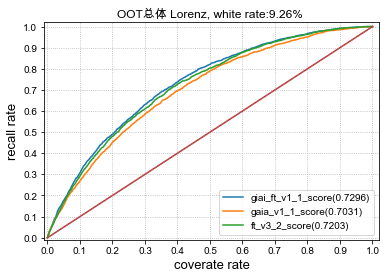

In [82]:
model_comparison_lorenz_curve(model_data.query("pboc2_0_score > 0 and source=='1.OOT' and dpd30_at_mob6==[0, 1]"),model_score_columns_list=['giai_ft_v1_1_score','gaia_v1_1_score', 'ft_v3_2_score'],target='dpd30_at_mob6')

In [84]:
def model_comparison_effect_cross(df,base_model_name,compare_model_name,target,bins):
    bins_label = ["(%d%%,%d%%]"%(i*100/bins,100/bins*(i+1)) for i in range(bins)]
    df_temp = df[[target,base_model_name,compare_model_name]].query("{0}>=0".format(target))
    df_temp[base_model_name] = pd.qcut(df_temp[base_model_name],q=bins,labels=bins_label)
    df_temp[compare_model_name] = pd.qcut(df_temp[compare_model_name],q=bins,labels=bins_label)

    display(pd.crosstab(
        df_temp[base_model_name],
        df_temp[compare_model_name],
        df_temp[target],
        aggfunc='mean',
        margins=True
    ))
    
    display(pd.crosstab(
        df_temp[base_model_name],
        df_temp[compare_model_name],
        df_temp[target],
        aggfunc='count',
        margins=True
    ))
    
model_comparison_effect_cross(df=model_data.query("pboc2_0_score > 0 and source=='1.OOT' and dpd30_at_mob6!=[-9999,-1]"),base_model_name='gaia_v1_1_score',compare_model_name='giai_ft_v1_1_score',target='dpd30_at_mob6',bins=5)

giai_ft_v1_1_score,"(0%,20%]","(20%,40%]","(40%,60%]","(60%,80%]","(80%,100%]",All
gaia_v1_1_score,,,,,,
"(0%,20%]",0.241463,0.142254,0.048507,0.093220,0.043478,0.208898
"(20%,40%]",0.177305,0.116020,0.068340,0.016760,0.058824,0.112187
"(40%,60%]",0.216216,0.100874,0.075395,0.039589,0.010204,0.074881
"(60%,80%]",0.222222,0.088235,0.054734,0.040596,0.019362,0.043290
"(80%,100%]",NaN,0.333333,0.066667,0.041348,0.012722,0.022871
All,0.226449,0.114784,0.066063,0.040136,0.015399,0.092577


giai_ft_v1_1_score,"(0%,20%]","(20%,40%]","(40%,60%]","(60%,80%]","(80%,100%]",All
gaia_v1_1_score,,,,,,
"(0%,20%]",3309,710,268,118,23,4428
"(20%,40%]",987,2241,717,358,136,4439
"(40%,60%]",111,1259,1963,682,392,4407
"(60%,80%]",9,204,1352,1946,878,4389
"(80%,100%]",0,3,120,1306,2987,4416
All,4416,4417,4420,4410,4416,22079
